<a href="https://colab.research.google.com/github/Ashi743/pytorch/blob/main/cnn_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import numpy
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn


In [8]:
torch.manual_seed(42)

In [9]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.csv'):  # Check if the file ends with '.csv'
            files = os.path.join(dirname, filename)
            print(files)

100%|██████████| 68.8M/68.8M [00:04<00:00, 15.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv


In [5]:
train= pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv")
test = pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv")

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [11]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


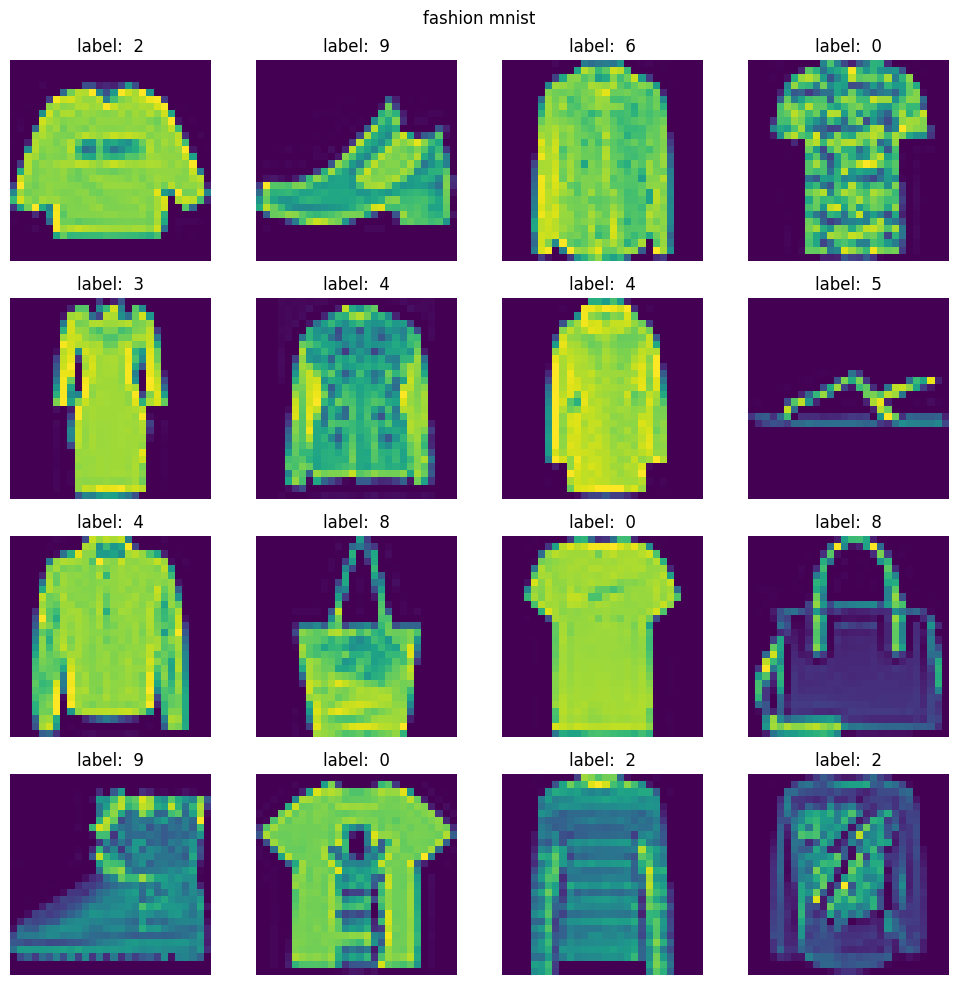

In [12]:
fig, ax = plt.subplots(ncols=4, nrows= 4, figsize=(10,10))
fig.suptitle("fashion mnist")
for i, ax in enumerate(ax.flat):
  img= train.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(f"label:  {train.iloc[i,0]}")
  ax.set_aspect("equal")

plt.tight_layout()
plt.show()

In [13]:
X= train.iloc[:, 1:].values
Y= train.iloc[:, 0].values

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
X_train= X_train/255
X_test= X_test/255

In [16]:
#transformations
from torchvision import transforms

train_transform= transforms.Compose([
    #pilimage
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, translate= (0.1, 0.1)),
    transforms.ToTensor()
])

test_transform= transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [22]:
#customdataset
class customdataset(Dataset):
  def __init__(self, features, labels, transform= None):
    self.features= features
    self.labels= labels
    self.transform= transform

  def __getitem__(self, index):
    features, label =self.features[index], self.labels[index]
    features= features.reshape(28,28)
    if self.transform:
      features= self.transform(features)
    return features, label

  def __len__(self):
    return len(self.features)


In [23]:
#data augment transforms  in training data
train_dataset= customdataset(X_train, Y_train, train_transform)
test_dataset= customdataset(X_test, Y_test, test_transform)

In [28]:
import torch
import torch.nn as nn

class DynamicCNN(nn.Module):
    def __init__(self, num_conv_layers, num_filters, kernel_size, num_fc_layers, num_neurons, dropout_rate):
        super(DynamicCNN, self).__init__()

        layers = []
        in_channels = 1  # assuming grayscale images (1 channel)

        # Create convolutional layers
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = num_filters  # update input channels for next layer

        self.features = nn.Sequential(*layers)

        dummy_input = torch.randn(1, 1, 28, 28)  # Assuming grayscale image of size 28x28
        output_size = self.features(dummy_input).view(1, -1).size(1)

        # Create fully connected layers
        fc_layers = [nn.Flatten()]
        for _ in range(num_fc_layers):
            fc_layers.append(nn.Linear(output_size, num_neurons)) # Change input_size to output_size
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            output_size = num_neurons

        # Final output layer (10 classes for classification)
        fc_layers.append(nn.Linear(output_size, 10))

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

def objective(trial):
    # Hyperparameter search space
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_filters = trial.suggest_categorical("num_filters", [16, 32, 64,128])
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
    num_fc_layers = trial.suggest_int("num_fc_layers", 1, 3)
    fc_layer_size = trial.suggest_categorical("fc_layer_size", [64, 128, 256])
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_categorical("num_epochs", [5, 10, 15])

    # Initialize the model
    model = DynamicCNN(num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate).to(device)

    # DataLoader setup
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10  # Define your number of epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Corrected
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = len(test_loader.dataset)  # Calculate total number of test samples
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / total  # Compute accuracy
    return accuracy  # Return accuracy as the objective to optimize


In [30]:
#define optuna
pruner= optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=15)

[I 2025-02-17 09:54:27,366] A new study created in memory with name: no-name-c7bd4dd7-7d71-4770-9e95-f5976834c806
<ipython-input-29-a87483707ec4>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
<ipython-input-29-a87483707ec4>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
<ipython-input-29-a87483707ec4>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("w

KeyboardInterrupt: 

In [ ]:
print(study.best_params)

In [ ]:
print(study.best_value)